In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import sys

sys.path.append("../")

import os
import cv2
import numpy as np
from tqdm import tqdm
from typing import List
from pathlib import Path
from justpfm import justpfm
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from src.config import SALIENCY_MAP_PFM_PATH, IMAGES_PATH
from src.utils.file import get_files_recursive, get_experiment_id_from_file_path, get_set_id_from_file_path, get_set_str, get_sequence_id_from_file_path

In [51]:
if not os.path.exists(SALIENCY_MAP_PFM_PATH):
    print(f"❌ {Path(SALIENCY_MAP_PFM_PATH).resolve()} does not exist. Please run the global saliency computation script first.")
else:
    print(f"✅ You are good to go!")

✅ You are good to go!


In [52]:
def read_and_normalize_saliency_map(saliency_map_file_path: str) -> np.ndarray:
    """
    Read and normalize a saliency map.

    Args:
        saliency_map_file_path (str): The path to the saliency map file.

    Returns:
        np.ndarray: The normalized saliency map.
    """
    saliency_map = justpfm.read_pfm(saliency_map_file_path)
    saliency_map = np.squeeze(saliency_map).astype(np.float32)
    cv2.normalize(saliency_map, saliency_map, 0, 1, cv2.NORM_MINMAX)

    return saliency_map


def get_saliency_diffs(experiment_id: int) -> List[float]:
    """
    Get the mean absolute saliency differences between sets for a given experiment.

    Args:
        experiment_id (int): The experiment ID.

    Returns:
        List[float]: The list of mean absolute saliency differences.
    """
    saliency_map_file_paths = get_files_recursive(SALIENCY_MAP_PFM_PATH, "*.pfm")
    set0_saliency_map_file_paths = sorted(
        [
            p
            for p in saliency_map_file_paths
            if get_experiment_id_from_file_path(p) == experiment_id
            and get_set_id_from_file_path(p) == 0
        ]
    )
    set1_saliency_map_file_paths = sorted(
        [
            p
            for p in saliency_map_file_paths
            if get_experiment_id_from_file_path(p) == experiment_id
            and get_set_id_from_file_path(p) == 1
        ]
    )

    abs_diffs = []
    for set0_saliency_map_file_path, set1_saliency_map_file_path in tqdm(
        zip(set0_saliency_map_file_paths, set1_saliency_map_file_paths),
        desc=f"⌛ Processing experiment {experiment_id}...",
        total=len(set0_saliency_map_file_paths),
    ):
        set0_saliency_map = read_and_normalize_saliency_map(set0_saliency_map_file_path)
        set1_saliency_map = read_and_normalize_saliency_map(set1_saliency_map_file_path)

        # Calculate the absolute difference
        diff = np.abs(set0_saliency_map - set1_saliency_map)
        mean_abs_diff = np.mean(diff)
        abs_diffs.append(mean_abs_diff)

    return abs_diffs


def plot_saliency_map_abs_difference() -> None:
    """
    Plot the mean absolute saliency differences between sets for both experiments.
    """
    
    # Get absolute differences for both experiments
    diffs_exp1 = get_saliency_diffs(experiment_id=1)
    diffs_exp2 = get_saliency_diffs(experiment_id=2)

    # Combine the results and create labels
    sequence_ids = [[
        get_sequence_id_from_file_path(p)
        for p in sorted(get_files_recursive(SALIENCY_MAP_PFM_PATH, "*.pfm"))
        if get_experiment_id_from_file_path(p) == exp_id and get_set_id_from_file_path(p) == 0
    ] for exp_id in [1, 2]]
    sequence_ids = sequence_ids[0] + sequence_ids[1]
    all_diffs = diffs_exp1 + diffs_exp2
    exp_labels = ['Exp 1'] * len(diffs_exp1) + ['Exp 2'] * len(diffs_exp2)
    scene_labels = [f"Scene {sequence_id}" for sequence_id in sequence_ids]

    # Create the bar plot
    _, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars
    ax.bar(range(len(all_diffs)), all_diffs, color=['blue'] * len(diffs_exp1) + ['green'] * len(diffs_exp2))
    
    # Set up two-level x-axis labels
    ax.set_xticks(range(len(all_diffs)))
    ax.set_xticklabels([f'{exp}\n{scene}' for exp, scene in zip(exp_labels, scene_labels)], rotation=90)

    # Set labels and title
    ax.set_ylabel("Mean Absolute Saliency Difference")
    ax.set_title("Comparison of Mean Absolute Saliency Differences")

    plt.tight_layout()
    plt.show()

⌛ Processing experiment 2...: 100%|██████████| 10/10 [00:00<00:00, 60.51it/s]


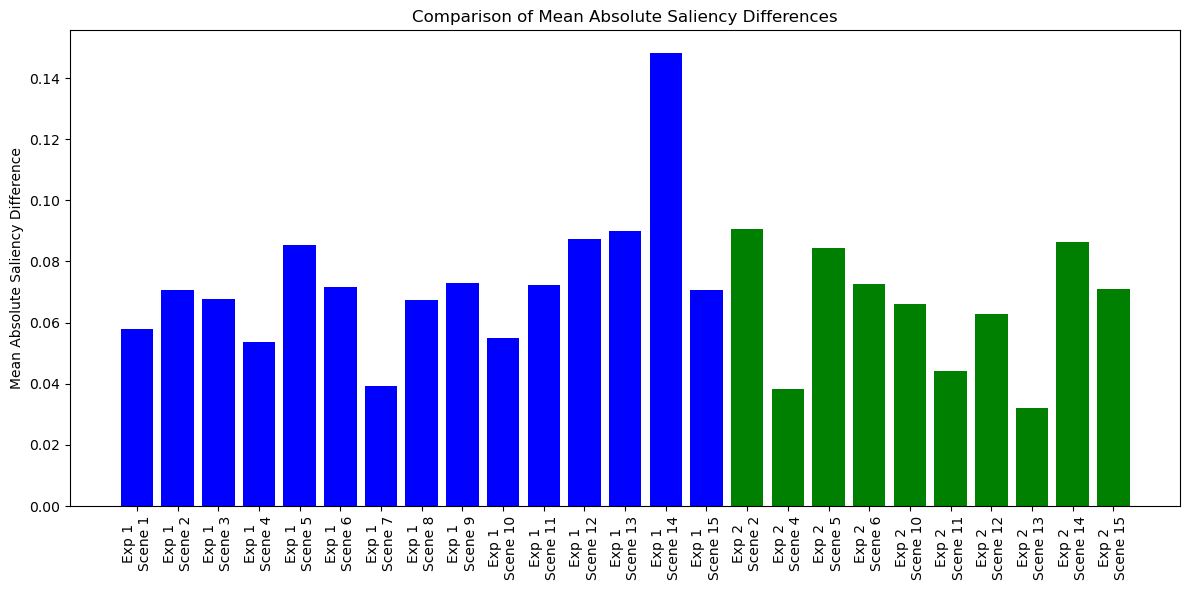

In [53]:
plot_saliency_map_abs_difference()

In [54]:
def get_saliency_bound_diffs(experiment_id: int) -> list:
    saliency_map_file_paths = get_files_recursive(SALIENCY_MAP_PFM_PATH, "*.pfm")
    set0_saliency_map_file_paths = sorted(
        [
            p
            for p in saliency_map_file_paths
            if get_experiment_id_from_file_path(p) == experiment_id
            and get_set_id_from_file_path(p) == 0
        ]
    )
    set1_saliency_map_file_paths = sorted(
        [
            p
            for p in saliency_map_file_paths
            if get_experiment_id_from_file_path(p) == experiment_id
            and get_set_id_from_file_path(p) == 1
        ]
    )

    bound_diffs = []
    for set0_saliency_map_file_path, set1_saliency_map_file_path in tqdm(
        zip(set0_saliency_map_file_paths, set1_saliency_map_file_paths),
        desc=f"⌛ Processing experiment {experiment_id}...",
        total=len(set0_saliency_map_file_paths),
    ):
        set0_saliency_map = read_and_normalize_saliency_map(set0_saliency_map_file_path)
        set1_saliency_map = read_and_normalize_saliency_map(set1_saliency_map_file_path)

        # Calculate the absolute difference
        diff = set0_saliency_map - set1_saliency_map
        bound_diff = np.max(np.abs(diff)) - np.min(np.abs(diff))
        bound_diffs.append(bound_diff)

    return bound_diffs


def get_saliency_map_bound_difference():
    # Get absolute differences for both experiments
    diffs_exp1 = get_saliency_bound_diffs(experiment_id=1)
    diffs_exp2 = get_saliency_bound_diffs(experiment_id=2)

    # Combine the results and create labels
    sequence_ids = [[
        get_sequence_id_from_file_path(p)
        for p in sorted(get_files_recursive(SALIENCY_MAP_PFM_PATH, "*.pfm"))
        if get_experiment_id_from_file_path(p) == experiment_id and get_set_id_from_file_path(p) == 0
    ] for experiment_id in [1, 2]]
    sequence_ids = sequence_ids[0] + sequence_ids[1]
    all_diffs = diffs_exp1 + diffs_exp2
    exp_labels = ['Exp 1'] * len(diffs_exp1) + ['Exp 2'] * len(diffs_exp2)
    scene_labels = [f"Scene {sequence_id}" for sequence_id in sequence_ids]

    # Create the bar plot
    _, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars
    ax.bar(range(len(all_diffs)), all_diffs, color=['blue'] * len(diffs_exp1) + ['green'] * len(diffs_exp2))
    
    # Set up two-level x-axis labels
    ax.set_xticks(range(len(all_diffs)))
    ax.set_xticklabels([f'{exp}\n{scene}' for exp, scene in zip(exp_labels, scene_labels)], rotation=90)

    # Set labels and title
    ax.set_ylabel("Saliency Map Max-Min Bound Difference")
    ax.set_title("Comparison of Saliency Map Max-Min Bound Differences")

    plt.tight_layout()
    plt.show()

⌛ Processing experiment 2...: 100%|██████████| 10/10 [00:00<00:00, 54.46it/s]


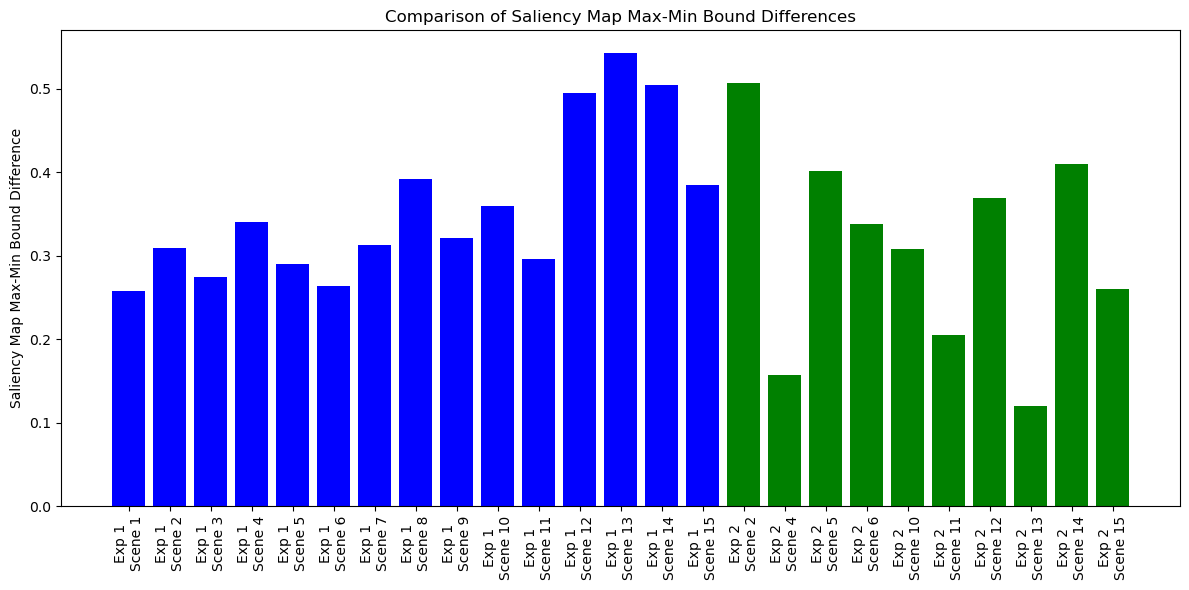

In [55]:
get_saliency_map_bound_difference()

In [56]:
def get_saliency_map_difference(experiment_id: int):
    saliency_map_file_paths = get_files_recursive(SALIENCY_MAP_PFM_PATH, "*.pfm")
    set0_saliency_map_file_paths = [
        p
        for p in saliency_map_file_paths
        if get_experiment_id_from_file_path(p) == experiment_id
        and get_set_id_from_file_path(p) == 0
    ]
    set0_saliency_map_file_paths = sorted(set0_saliency_map_file_paths)
    set1_saliency_map_file_paths = [
        p
        for p in saliency_map_file_paths
        if get_experiment_id_from_file_path(p) == experiment_id
        and get_set_id_from_file_path(p) == 1
    ]
    set1_saliency_map_file_paths = sorted(set1_saliency_map_file_paths)
    image_file_paths = get_files_recursive(IMAGES_PATH, "*.png")
    set0_image_file_paths = [
        p
        for p in image_file_paths
        if get_experiment_id_from_file_path(p) == experiment_id
        and get_set_id_from_file_path(p) == 0
    ]
    set0_image_file_paths = sorted(set0_image_file_paths)
    set1_image_file_paths = [
        p
        for p in image_file_paths
        if get_experiment_id_from_file_path(p) == experiment_id
        and get_set_id_from_file_path(p) == 1
    ]
    set1_image_file_paths = sorted(set1_image_file_paths)

    for (
        set0_saliency_map_file_path,
        set1_saliency_map_file_path,
        set0_image_file_path,
        set1_image_file_path,
    ) in tqdm(
        zip(
            set0_saliency_map_file_paths,
            set1_saliency_map_file_paths,
            set0_image_file_paths,
            set1_image_file_paths,
        ),
        desc="⌛ Comparing saliency maps...",
        total=len(set0_saliency_map_file_paths),
    ):
        set0_saliency_map = justpfm.read_pfm(set0_saliency_map_file_path)
        set0_saliency_map = np.squeeze(set0_saliency_map).astype(np.float32)
        set1_saliency_map = justpfm.read_pfm(set1_saliency_map_file_path)
        set1_saliency_map = np.squeeze(set1_saliency_map).astype(np.float32)
        cv2.normalize(set0_saliency_map, set0_saliency_map, 0, 1, cv2.NORM_MINMAX)
        cv2.normalize(set1_saliency_map, set1_saliency_map, 0, 1, cv2.NORM_MINMAX)
        diff = set0_saliency_map - set1_saliency_map

        set0_image = cv2.imread(set0_image_file_path)
        set1_image = cv2.imread(set1_image_file_path)

        set0_str = get_set_str(experiment_id=experiment_id, set_id=0)
        set1_str = get_set_str(experiment_id=experiment_id, set_id=1)
        sequence_id = get_sequence_id_from_file_path(file_path=set0_saliency_map_file_path)
        plt.figure(figsize=(13, 2))
        plt.subplot(1, 3, 1)
        plt.imshow(set0_image)
        plt.imshow(set0_saliency_map, alpha=0.75, cmap="hot")
        plt.colorbar()
        plt.title(f"{set0_str.capitalize()} saliency map")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(set1_image)
        plt.imshow(set1_saliency_map, alpha=0.75, cmap="hot")
        plt.colorbar()
        plt.title(f"{set1_str.capitalize()} saliency map")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(set0_image)
        norm = TwoSlopeNorm(vmin=np.min(diff), vcenter=0, vmax=np.max(diff))
        plt.imshow(diff, alpha=0.75, cmap="coolwarm", norm=norm)
        plt.colorbar()
        plt.title(f"Set saliency map difference\n({set0_str} - {set1_str})")
        plt.axis("off")
        plt.suptitle(f"Experiment {experiment_id} Sequence {sequence_id}")
        plt.tight_layout()
        plt.show()

⌛ Comparing saliency maps...:   0%|          | 0/15 [00:00<?, ?it/s]

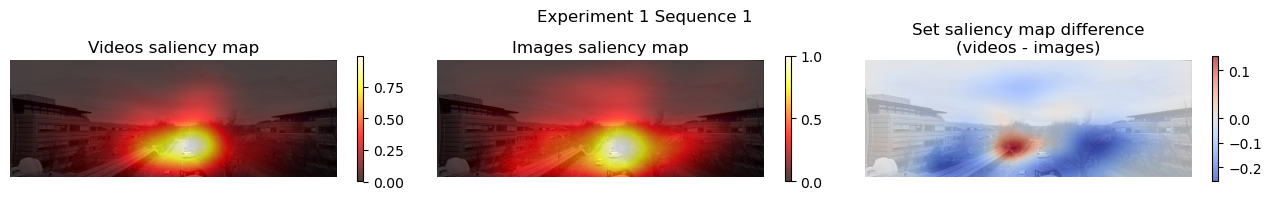

⌛ Comparing saliency maps...:   7%|▋         | 1/15 [00:00<00:09,  1.49it/s]

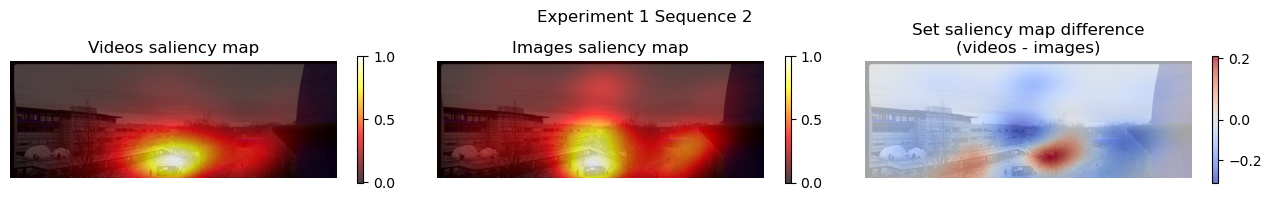

⌛ Comparing saliency maps...:  13%|█▎        | 2/15 [00:01<00:07,  1.64it/s]

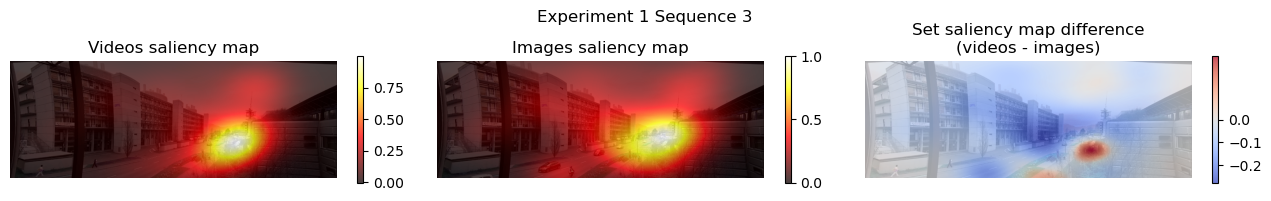

⌛ Comparing saliency maps...:  20%|██        | 3/15 [00:01<00:07,  1.67it/s]

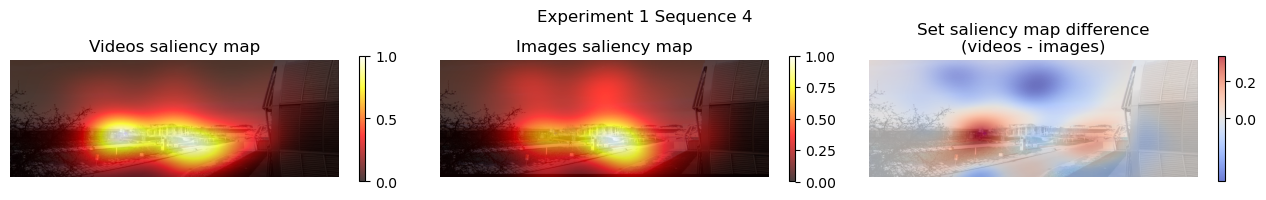

⌛ Comparing saliency maps...:  27%|██▋       | 4/15 [00:02<00:06,  1.68it/s]

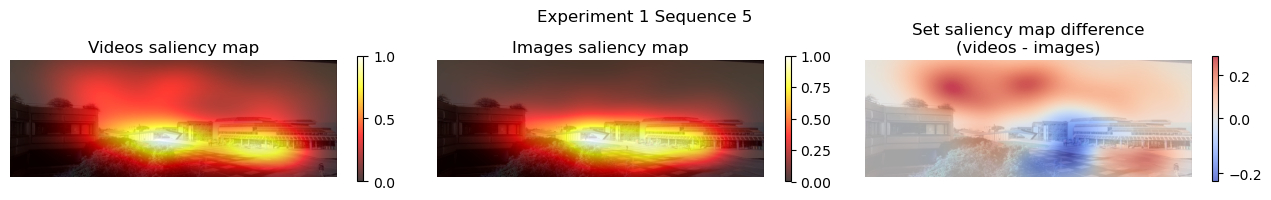

⌛ Comparing saliency maps...:  33%|███▎      | 5/15 [00:02<00:05,  1.70it/s]

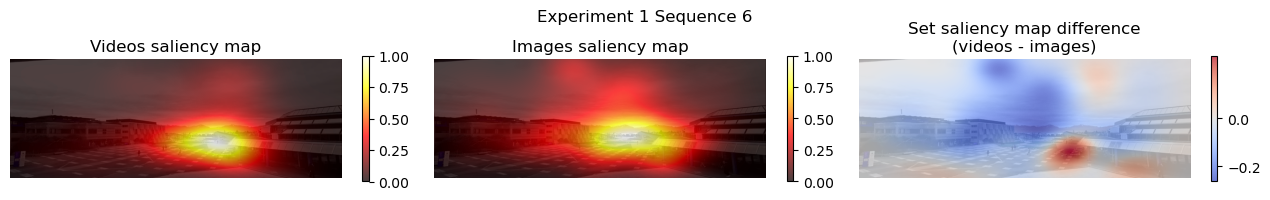

⌛ Comparing saliency maps...:  40%|████      | 6/15 [00:03<00:05,  1.70it/s]

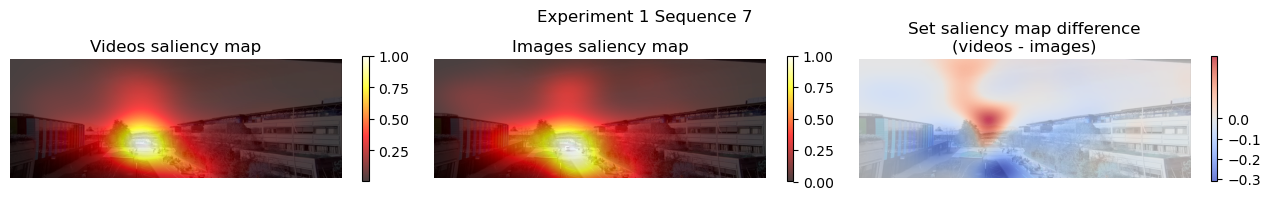

⌛ Comparing saliency maps...:  47%|████▋     | 7/15 [00:04<00:04,  1.63it/s]

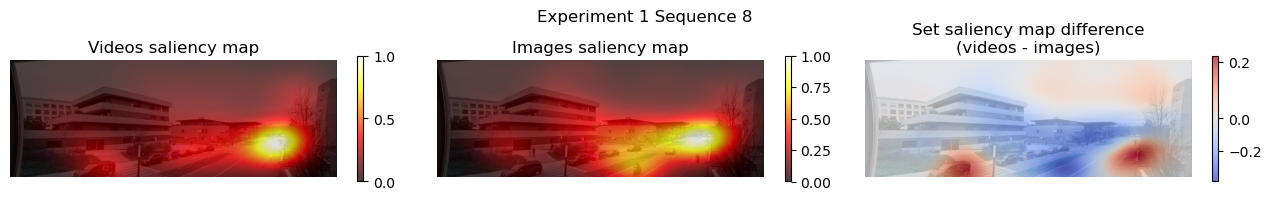

⌛ Comparing saliency maps...:  53%|█████▎    | 8/15 [00:04<00:04,  1.63it/s]

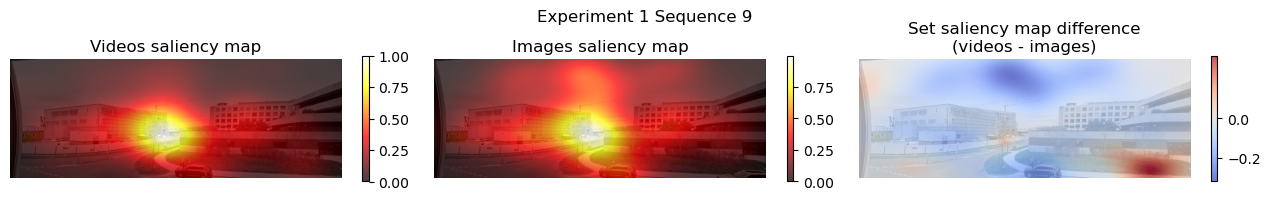

⌛ Comparing saliency maps...:  60%|██████    | 9/15 [00:05<00:03,  1.64it/s]

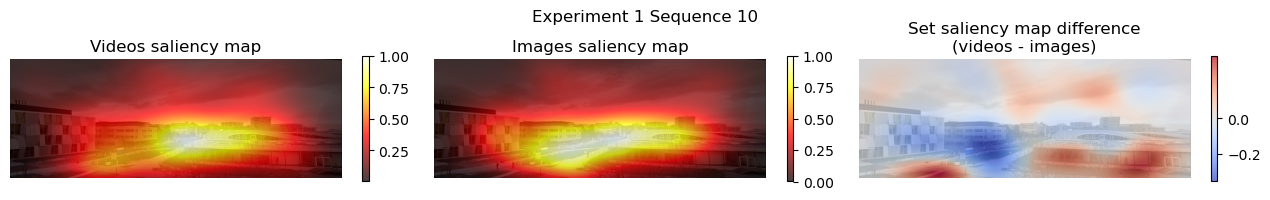

⌛ Comparing saliency maps...:  67%|██████▋   | 10/15 [00:06<00:03,  1.64it/s]

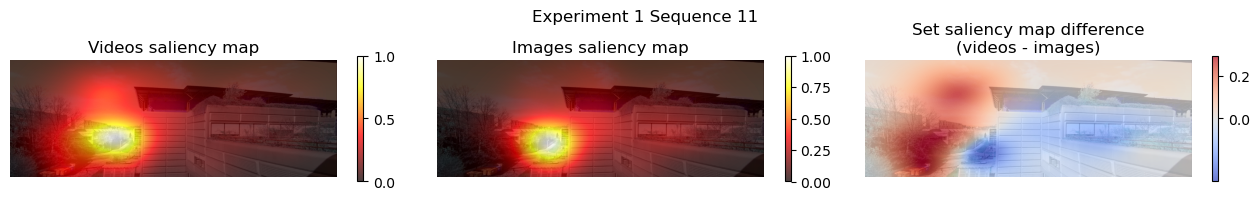

⌛ Comparing saliency maps...:  73%|███████▎  | 11/15 [00:06<00:02,  1.66it/s]

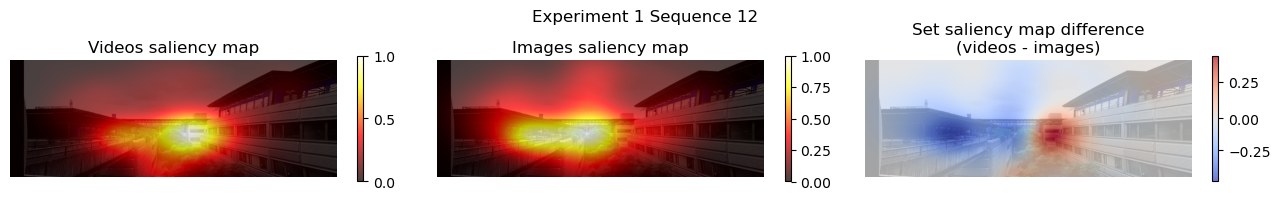

⌛ Comparing saliency maps...:  80%|████████  | 12/15 [00:07<00:01,  1.57it/s]

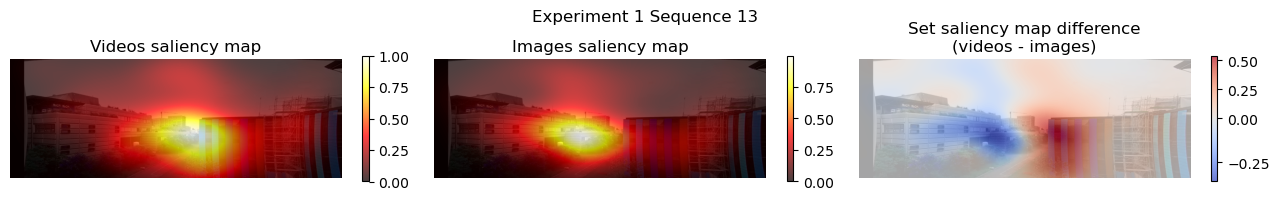

⌛ Comparing saliency maps...:  87%|████████▋ | 13/15 [00:07<00:01,  1.61it/s]

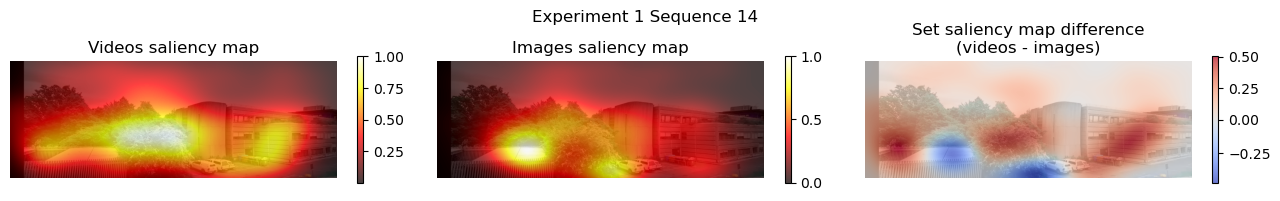

⌛ Comparing saliency maps...:  93%|█████████▎| 14/15 [00:08<00:00,  1.63it/s]

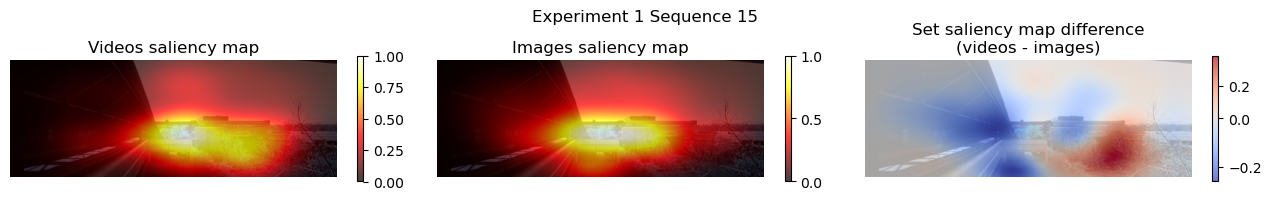

⌛ Comparing saliency maps...: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


In [57]:
get_saliency_map_difference(experiment_id=1)

⌛ Comparing saliency maps...:   0%|          | 0/10 [00:00<?, ?it/s]

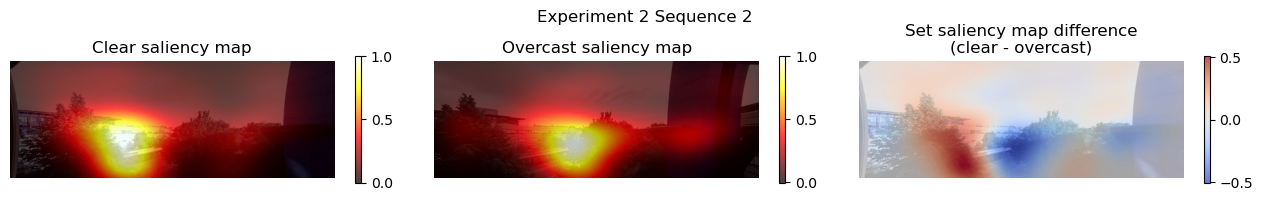

⌛ Comparing saliency maps...:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]

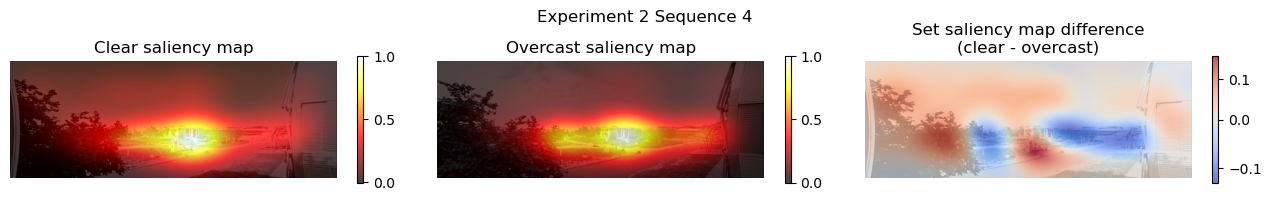

⌛ Comparing saliency maps...:  20%|██        | 2/10 [00:01<00:04,  1.76it/s]

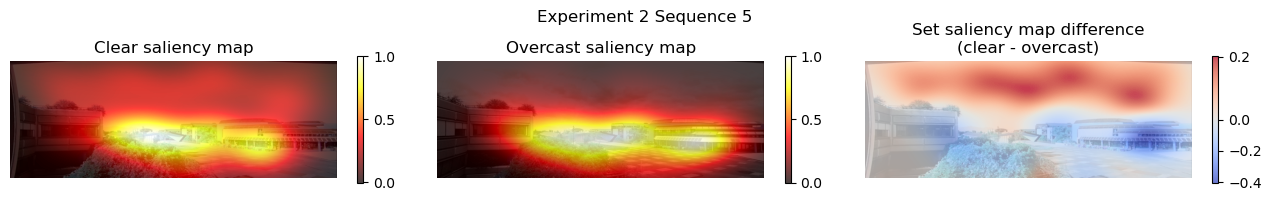

⌛ Comparing saliency maps...:  30%|███       | 3/10 [00:01<00:04,  1.64it/s]

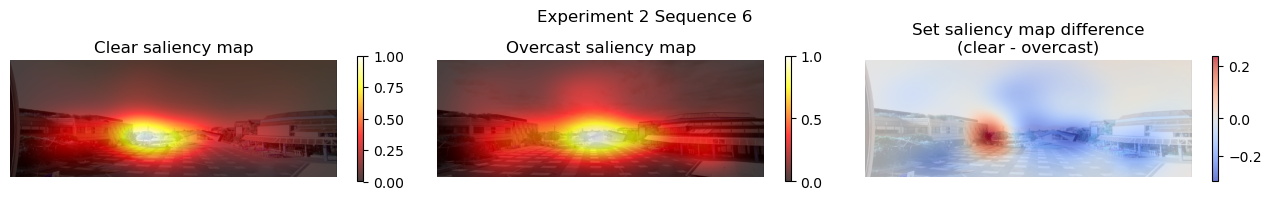

⌛ Comparing saliency maps...:  40%|████      | 4/10 [00:02<00:03,  1.69it/s]

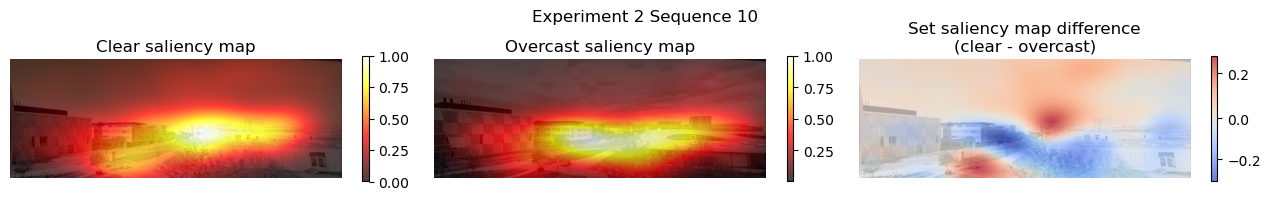

⌛ Comparing saliency maps...:  50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

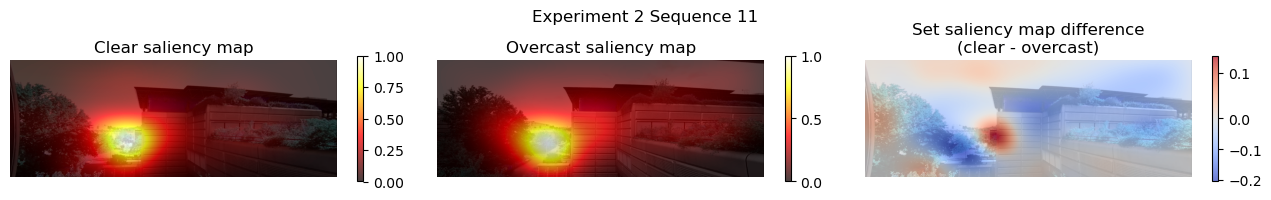

⌛ Comparing saliency maps...:  60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

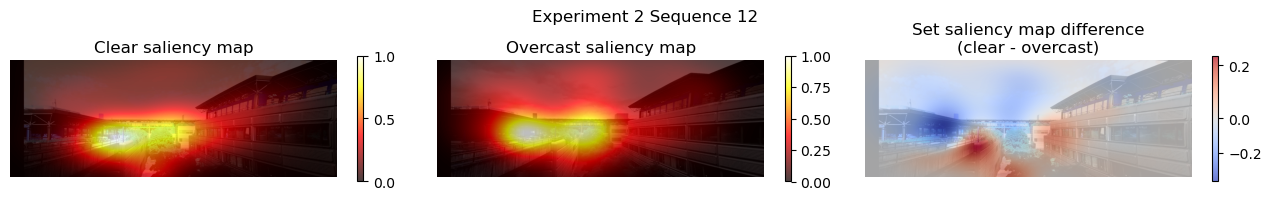

⌛ Comparing saliency maps...:  70%|███████   | 7/10 [00:04<00:01,  1.72it/s]

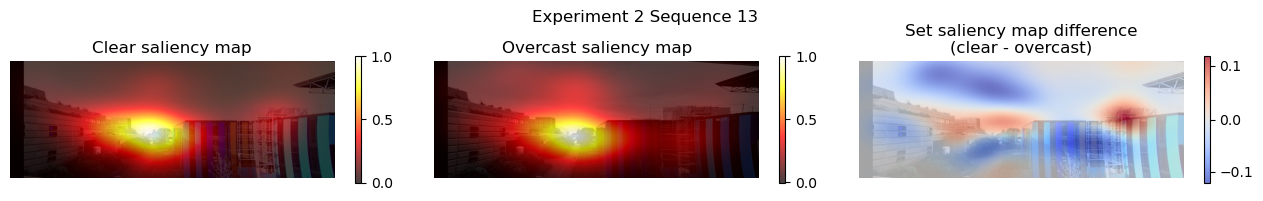

⌛ Comparing saliency maps...:  80%|████████  | 8/10 [00:04<00:01,  1.73it/s]

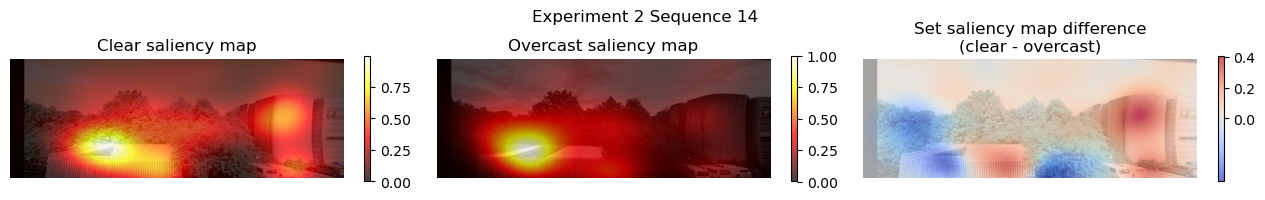

⌛ Comparing saliency maps...:  90%|█████████ | 9/10 [00:05<00:00,  1.65it/s]

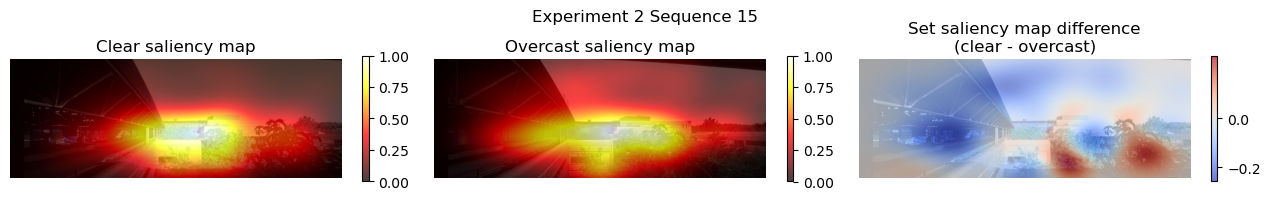

⌛ Comparing saliency maps...: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


In [58]:
get_saliency_map_difference(experiment_id=2)